In [0]:
# Install pyspark and initiate
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.6.tgz
!tar xf spark-2.4.5-bin-hadoop2.6.tgz
!pip install -q findspark

In [0]:
#Envirnoment set up
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.6"

In [0]:
#Spark session creation
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
#Import libraries
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
#Creating an object to run SparkContext and configuration parameters set up
sc = spark.sparkContext
spark.conf.set("spark.executor.memory", '8g')
spark.conf.set('spark.executor.cores', '3')
spark.conf.set('spark.cores.max', '3')
spark.conf.set("spark.driver.memory",'8g')

In [6]:
#Drive mounting 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Reading data file from drive
import pandas as pd 
df = pd.read_csv('/content/drive/My Drive/als_preprocessed.csv')

In [8]:
#Data view 
df.head()

,userID,productID,rating
0,19236.0,26144.0,5.0
1,48511.0,32800.0,5.0
2,3549.0,18426.0,5.0
3,57166.0,27789.0,5.0
4,44574.0,2863.0,5.0


In [9]:
#Rows and columns in the data 
df.shape

(60605, 3)

### 1. Load the RDD Dataframe

In [0]:
ratings = sc.textFile('/content/drive/My Drive/als_preprocessed1.csv')

# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()

In [34]:
rating_data.take(4)

[(19236, 26144, 5.0),
 (48511, 32800, 5.0),
 (3549, 18426, 5.0),
 (57166, 27789, 5.0)]

### 2. Train-test-validation split

In [36]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[63] at RDD at PythonRDD.scala:53

### 3. Model Training

In [0]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [43]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)
print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 5.655162499059731
8 latent factors and regularization = 0.01: validation RMSE is 5.187068199803452
8 latent factors and regularization = 0.05: validation RMSE is 5.007580323801328
8 latent factors and regularization = 0.1: validation RMSE is 4.96931601131744
8 latent factors and regularization = 0.2: validation RMSE is 4.938664665314195
10 latent factors and regularization = 0.001: validation RMSE is 5.204616550319458
10 latent factors and regularization = 0.01: validation RMSE is 4.877448775544241
10 latent factors and regularization = 0.05: validation RMSE is 4.806006965636591
10 latent factors and regularization = 0.1: validation RMSE is 4.786467058730118
10 latent factors and regularization = 0.2: validation RMSE is 4.767400968779442
12 latent factors and regularization = 0.001: validation RMSE is 5.17407898949525
12 latent factors and regularization = 0.01: validation RMSE is 4.8536990569341105
12 latent factors and r

### 4. Learning Curves

In [0]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

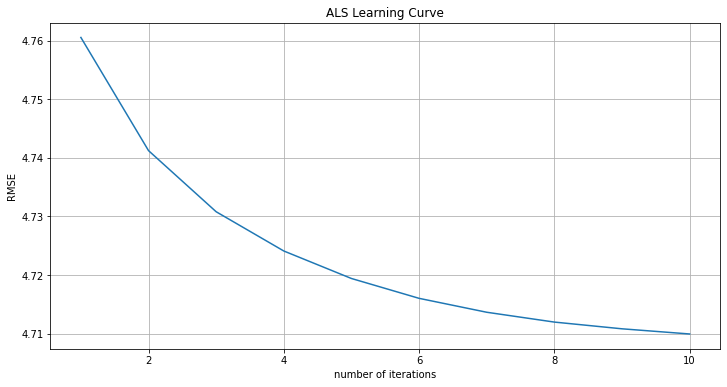

In [45]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

### 5. Test Data RMSE

In [46]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 4.7028


### 6. Load Titles for Products

In [0]:
#Load the titles dataset
title = spark.read.load('/content/drive/My Drive/title_data_csv', format='csv', header=True, inferSchema=True)
data = spark.read.load('/content/drive/My Drive/als_preprocessed1.csv', format='csv', header=True, inferSchema=True)

In [50]:
title.show(20)

+----------+--------------------+
|      asin|               title|
+----------+--------------------+
|0001487795|You Are Special T...|
|0002020300|Vicks Inhaler Rel...|
|0006564224|Artistic Churchwa...|
|0009046461|4 BARS! Mysore Sa...|
|0234937912|AROGYA VATI (40gm...|
|0250459655|Nikola Tesla Phot...|
|0326591516|Set of 15 Cello B...|
|0439903491|Scholastic Pirate...|
|0456680012|My Little Pony Eq...|
|0470902884|The Great Workpla...|
|0555667502|Insulated Lunch B...|
|0560467893|WELLAND Chicago W...|
|0587228237|Gary Trucking Co....|
|0594496780|Barnes and Noble ...|
|0615444261|Gulf Coast Kitche...|
|0635118777|Gallopade Publish...|
|063511769X|Gallopade Publish...|
|0641965974|Text Me Coffee Mu...|
|0681795107|Stainless Coffee Mug|
|0735328889|Mudpuppy Monkey W...|
+----------+--------------------+
only showing top 20 rows



In [55]:
title.createOrReplaceTempView("title")
data.createOrReplaceTempView("ratings")
spark.sql(
    "SELECT m.asin, m.title "
     "FROM title m LEFT JOIN ratings r ON m.asin = r.productID "
     "WHERE r.productID IS NULL"
 ).show(20)

+----------+--------------------+
|      asin|               title|
+----------+--------------------+
|0001487795|You Are Special T...|
|0002020300|Vicks Inhaler Rel...|
|0006564224|Artistic Churchwa...|
|0009046461|4 BARS! Mysore Sa...|
|0234937912|AROGYA VATI (40gm...|
|0250459655|Nikola Tesla Phot...|
|0326591516|Set of 15 Cello B...|
|0439903491|Scholastic Pirate...|
|0456680012|My Little Pony Eq...|
|0470902884|The Great Workpla...|
|0555667502|Insulated Lunch B...|
|0560467893|WELLAND Chicago W...|
|0587228237|Gary Trucking Co....|
|0594496780|Barnes and Noble ...|
|0615444261|Gulf Coast Kitche...|
|0635118777|Gallopade Publish...|
|063511769X|Gallopade Publish...|
|0641965974|Text Me Coffee Mu...|
|0681795107|Stainless Coffee Mug|
|0735328889|Mudpuppy Monkey W...|
+----------+--------------------+
only showing top 20 rows



### 7. Prediction on Items

In [ ]:
def get_productId(data, fav_item_list):
    items = []
    for item in fav_item_list:
        itemIds = data \
            .filter(titles.title.like('%{}%'.format(title))) \
            .select('asin') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
          items.extend(itemIds)
    return list(set(items))